Importujemy potrzebne biblioteki

In [3]:
#Importujemy biblioteki potrzebne do uczenia naszego modelu
import os
import json
import unittest
import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Importujemy biblioteki potrzebne do OpenAI
from openai import OpenAI
import random
from sklearn.metrics import classification_report, accuracy_score

Pobieramy i przetwarzamy dane

In [8]:
# URL do pobrania danych
_URL = "https://raw.githubusercontent.com/cblancac/SentimentAnalysisBert/main/data/"
_URLS = {
    "train": _URL + "train_150k.txt",
    "test": _URL + "test_62k.txt"
}

# Funkcja przetwarzająca dane
def _define_columns(example):
    text_splited = example["text"].split('\t')
    return {"text": text_splited[1].strip(), "feeling": int(text_splited[0])}

# Pobranie danych
data = datasets.load_dataset("text", data_files=_URLS)

# Przetwarzanie danych
data = data.map(_define_columns)

# Podział na zbiory treningowy, walidacyjny i testowy
texts_dataset_clean = data["train"].train_test_split(train_size=0.8, seed=42)

# Zmiana nazwy zbioru testowego na walidacyjny i przypisanie oryginalnego zbioru testowego
texts_dataset_clean["validation"] = texts_dataset_clean.pop("test")
texts_dataset_clean["test"] = data["test"]

# Ścieżka do zapisu danych w lokalnym folderze roboczym
output_dir = os.getcwd()

# Zapisanie danych do plików JSONL
for split, dataset in texts_dataset_clean.items():
    dataset.to_json(os.path.join(output_dir, f"twitter-sentiment-analysis-{split}.jsonl"))

Creating json from Arrow format: 100%|██████████| 62/62 [00:00<00:00, 298.14ba/s]


Wczytujemy dane z przygotowanych plików JSONL

In [5]:
train_data = pd.read_json("twitter-sentiment-analysis-train.jsonl", lines=True)
val_data = pd.read_json("twitter-sentiment-analysis-validation.jsonl", lines=True)
test_data = pd.read_json("twitter-sentiment-analysis-test.jsonl", lines=True)

X_train, y_train = train_data["text"], train_data["feeling"]
X_val, y_val = val_data["text"], val_data["feeling"]
X_test, y_test = test_data["text"], test_data["feeling"]

Przygotowujemy dane

In [6]:
max_words = 20000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

Budujemy i trenujemy model

In [148]:
# Definicja modelu
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Trenowanie modelu z EarlyStopping
history = model.fit(
    X_train_pad, y_train,
    epochs=30,
    batch_size=256,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping]
)


Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 116s 240ms/step - accuracy: 0.6970 - loss: 0.7999 - val_accuracy: 0.7901 - val_loss: 0.4599
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 114s 243ms/step - accuracy: 0.8172 - loss: 0.4171 - val_accuracy: 0.7942 - val_loss: 0.4465
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 112s 238ms/step - accuracy: 0.8390 - loss: 0.3703 - val_accuracy: 0.7914 - val_loss: 0.4665
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 115s 245ms/step - accuracy: 0.8604 - loss: 0.3279 - val_accuracy: 0.7882 - val_loss: 0.4856
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 116s 247ms/step - accuracy: 0.8764 - loss: 0.2923 - val_accuracy: 0.7866 - val_loss: 0.5226
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 116s 247ms/step - accuracy: 0.8927 - loss: 0.2592 - val_accuracy: 0.7810 - val_loss: 0.5859
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 114s 242ms/step - accuracy: 0.9086 - loss: 0.2281 - val_accuracy: 0.7764 - val_loss: 0.6471
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 112s 238ms/step - accuracy: 0.9153 -

Wyświetlamy wykres dokładności modelu

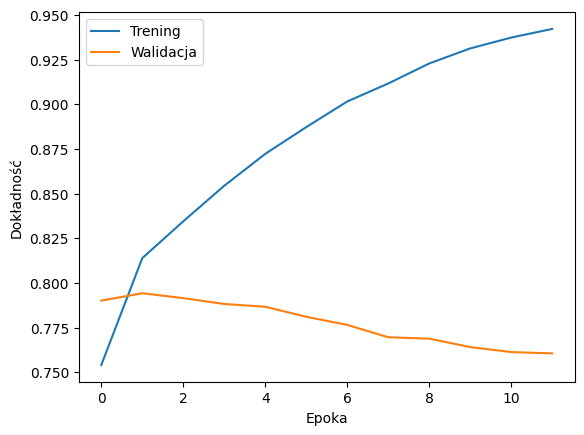

1938/1938 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - accuracy: 0.7902 - loss: 0.4486
Dokładność na zbiorze testowym: 0.79


In [150]:
plt.plot(history.history['accuracy'], label='Trening')
plt.plot(history.history['val_accuracy'], label='Walidacja')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(X_test_pad, y_test)
print(f'Dokładność na zbiorze testowym: {test_acc:.2f}')

Wyświetlamy przykładowe predykcje i rzeczywiste etykiety

In [ ]:
print('Przykładowe predykcje:')

random_tweets = np.random.choice(len(X_test_pad), size=8, replace=False)
predictions = model.predict(X_test_pad[random_tweets])
for i, pred in enumerate(predictions):
    actual_label = y_test.iloc[random_tweets[i]] 
    print(f'\n Tweet: {X_test.iloc[i]} \n Predykcja: {"Pozytywna" if pred > 0.5 else "Negatywna"}, Rzeczywista etykieta: {"Pozytywna" if actual_label == 1 else "Negatywna"}')

Przykładowe predykcje:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

 Tweet: @justineville ...yeahhh. ) i'm 39 tweets from 1,600! 
 Predykcja: Negatywna, Rzeczywista etykieta: Negatywna

 Tweet: @ApplesnFeathers aww. Poor baby! On your only REAL day off. 
 Predykcja: Pozytywna, Rzeczywista etykieta: Pozytywna

 Tweet: @joeymcintyre With my refunded $225 (Australian ticket price) I bought me a hot pair of brown boots  Woulda rathered seeing U any day 
 Predykcja: Pozytywna, Rzeczywista etykieta: Negatywna

 Tweet: It's fine. Today sucks just because me those things. i dunno if i can see you 
 Predykcja: Pozytywna, Rzeczywista etykieta: Pozytywna

 Tweet: Im just chilling on psp and stuff, but sitting on pc now, also watching wimledon, getting ready for holiday @WhiteTigerNora Ahh poor you 
 Predykcja: Negatywna, Rzeczywista etykieta: Negatywna

 Tweet: @lisarinna very sad Lisa...she is freeeeeeeeeeee an Angel in Heaven xoxo 
 Predykcja: Negatywna, Rzeczywista etykieta: Negatywna

 Tweet: Comfo

Unit Testy

In [9]:
class TestTwitterSentimentAnalysis(unittest.TestCase):

    @classmethod
    def setUpClass(cls):
        global X_train_pad, X_val_pad, X_test_pad, max_len

        cls.X_train_pad = X_train_pad
        cls.X_val_pad = X_val_pad
        cls.X_test_pad = X_test_pad
        cls.max_len = max_len

    def test_tokenization_and_padding(self):
        # Sprawdzamy czy wszystkie sekwencje mają odpowiedni kształt
        self.assertEqual(self.X_train_pad.shape[1], self.max_len)
        self.assertEqual(self.X_val_pad.shape[1], self.max_len)
        self.assertEqual(self.X_test_pad.shape[1], self.max_len)

        # Sprawdzamy długość jednej sekwencji z każdego zestawu
        self.assertEqual(len(self.X_train_pad[0]), self.max_len)
        self.assertEqual(len(self.X_val_pad[0]), self.max_len)
        self.assertEqual(len(self.X_test_pad[0]), self.max_len)

        # Sprawdzamy czy wynik tokenizacji jest poprawny
        self.assertGreater(len(self.X_train_pad[0]), 0)
        self.assertGreater(len(self.X_val_pad[0]), 0)
        self.assertGreater(len(self.X_test_pad[0]), 0)

        # Sprawdzamy czy każdy token jest liczbą całkowitą (prawidłowa tokenizacja)
        for sequence in [self.X_train_pad, self.X_val_pad, self.X_test_pad]:
            for token_list in sequence:
                # Debugowanie: wydrukuj tokeny, które nie spełniają warunku
                for token in token_list:
                    if not (isinstance(token, (int, np.integer)) and token >= 0):
                        print(f"Nieprawidłowy token: {token} (typ: {type(token)})")

                self.assertTrue(all(isinstance(token, (int, np.integer)) and token >= 0 for token in token_list), "Tokenizacja nieprawidłowa: znaleziono niepoprawne tokeny")

    def test_define_columns(self):
        # Przykładowy tweet
        example = {"text": "1\tGood morning, friend!"}
        expected_output = {"text": "Good morning, friend!", "feeling": 1}
        result = _define_columns(example)
        self.assertEqual(result, expected_output)

    def test_jsonl_files(self):
        # Sprawdź, czy pliki JSONL są tworzone z odpowiednią strukturą
        data_dir = "." 
        train_file = os.path.join(data_dir, "twitter-sentiment-analysis-train.jsonl")
        validation_file = os.path.join(data_dir, "twitter-sentiment-analysis-validation.jsonl")
        test_file = os.path.join(data_dir, "twitter-sentiment-analysis-test.jsonl")

        # Sprawdź, czy pliki istnieją
        self.assertTrue(os.path.exists(train_file), "Plik treningowy nie istnieje")
        self.assertTrue(os.path.exists(validation_file), "Plik walidacyjny nie istnieje")
        self.assertTrue(os.path.exists(test_file), "Plik testowy nie istnieje")

        # Sprawdź strukturę pierwszego wpisu w każdym pliku JSONL ("text" i "feeling")
        with open(train_file, 'r', encoding='utf-8') as file:
            train_data = json.loads(file.readline())
            self.assertIn("text", train_data)
            self.assertIn("feeling", train_data)

        with open(validation_file, 'r', encoding='utf-8') as file:
            validation_data = json.loads(file.readline())
            self.assertIn("text", validation_data)
            self.assertIn("feeling", validation_data)

        with open(test_file, 'r', encoding='utf-8') as file:
            test_data = json.loads(file.readline())
            self.assertIn("text", test_data)
            self.assertIn("feeling", test_data)

unittest.main(argv=[''], exit=False)


...
----------------------------------------------------------------------
Ran 3 tests in 11.204s

OK


Przygotowujemy funkcje i potrzebne wartości do wysłania zapytań do API OpenAi

In [14]:
# Ładujemy dane z pliku jsonl
with open("twitter-sentiment-analysis-test.jsonl", "r", encoding="utf-8") as f:
    data = [json.loads(line) for line in f]

random.seed(96)  # Ustawiamy ziarno losowości dla powtarzalności wyników
sample_data = random.sample(data, 4500)

texts = [item['text'] for item in sample_data]
true_labels = [int(item['feeling']) for item in sample_data]  # Konwertujemy na liczby całkowite (0 lub 1)

# Ustawiamy klucz API OpenAI
openai = OpenAI(api_key="")

def classify_with_openai_in_batches(texts, batch_size, num_batches):
    results = []

    for batch_num in range(num_batches):
        # Obliczamy indeksy początkowy i końcowy dla batcha
        start_idx = batch_num * batch_size
        end_idx = start_idx + batch_size
        
        # Wyciągamy odpowiednią partię danych
        batch = texts[start_idx:end_idx]

        try:
            # Przygotowujemy dane wejściowe do formatu
            batch_texts = "\n".join([f"Text {i + 1}: \"{text}\"" for i, text in enumerate(batch)])
            messages = [
                {"role": "system", "content": "You are a sentiment analysis classifier."},
                {"role": "user", "content": f"Classify the sentiment of the following texts as 0 (negative) or 1 (positive) for every line of this list:\n[{batch_texts}]. Ensure the response is always a list of {batch_size} values (ones and zeros)."}
            ]

            # Wysyłamy zapytanie do API OpenAI
            response = openai.chat.completions.create(
                model="gpt-4o-mini",
                messages=messages
            )

            # Przetwarzamy odpowiedź
            content = response.choices[0].message.content.strip()
            batch_responses = json.loads(content)
            batch_responses = [int(val) for val in batch_responses if val in [0, 1]]

            # Dodajemy wyniki do głównej listy
            results.extend(batch_responses)

            print(f"Batch {batch_num + 1}:")
            for i, (text, pred, true) in enumerate(zip(batch, batch_responses, true_labels)):
                print(f"Próbka {i + 1}: Wartość: {text} | Predykcja: {pred} | Prawdziwa etykieta: {true}")
        
        # W przypadku błędu ustawiamy wyniki z batcha na 0
        except Exception as e:
            print(f"Błąd przetwarzania batcha: {num_batches}\nError: {e}")
            results.extend([0] * len(batch))

    return results

Pobieramy dane z API OpenAI i wyświetlamy dokładność, raport klasyfikacji oraz wykres Ground Truth

Pobieranie danych z OpenAI API...
Batch 1:
Próbka 1: Wartość: And if I should become a stranger know that it would make me very sad... | Predykcja: 0 | Prawdziwa etykieta: 0
Próbka 2: Wartość: Goodnight! Go watch PPP @ddlovato @selenagomez its amazing, made me cry when Demi was looking out the window crying :\ | Predykcja: 1 | Prawdziwa etykieta: 0
Próbka 3: Wartość: Made it 2 top of the 6th. MoÃ¯Â¿Â½se super cool. Makes us look like we know what we're doing  Thx ATT park for fam friendly stadium. | Predykcja: 1 | Prawdziwa etykieta: 1
Próbka 4: Wartość: @KateyinIdaho I agree!!!    did you go to the spokane conference? | Predykcja: 1 | Prawdziwa etykieta: 1
Próbka 5: Wartość: All my illadelph peoples moved out the 215... now I have zero access to trees | Predykcja: 0 | Prawdziwa etykieta: 0
Próbka 6: Wartość: Starting work on Friday! Cant wait  Hope everyone had a good weekend! I did ;) | Predykcja: 1 | Prawdziwa etykieta: 1
Próbka 7: Wartość: @opinionatedant Have a great weekend Monon

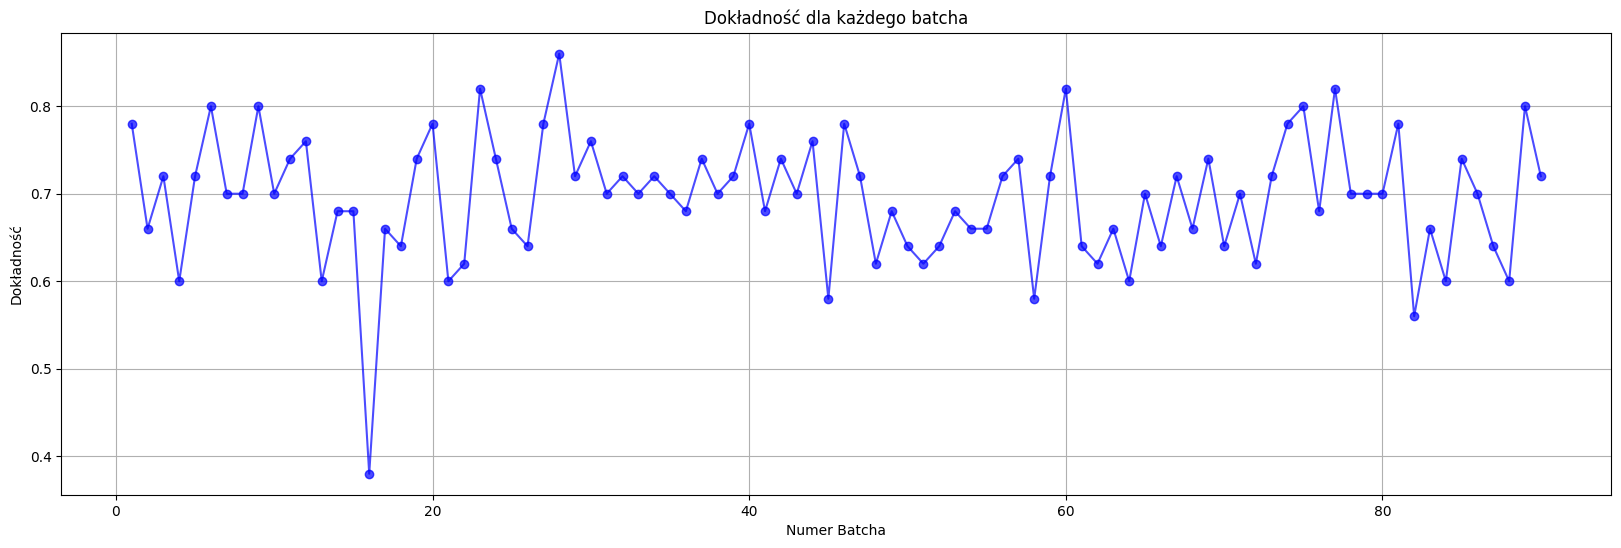

Dokładność OpenAI API: 0.70
Raport klasyfikacji OpenAI API:
              precision    recall  f1-score   support

           0       0.67      0.76      0.71      2249
           1       0.73      0.63      0.67      2251

    accuracy                           0.70      4500
   macro avg       0.70      0.70      0.69      4500
weighted avg       0.70      0.70      0.69      4500



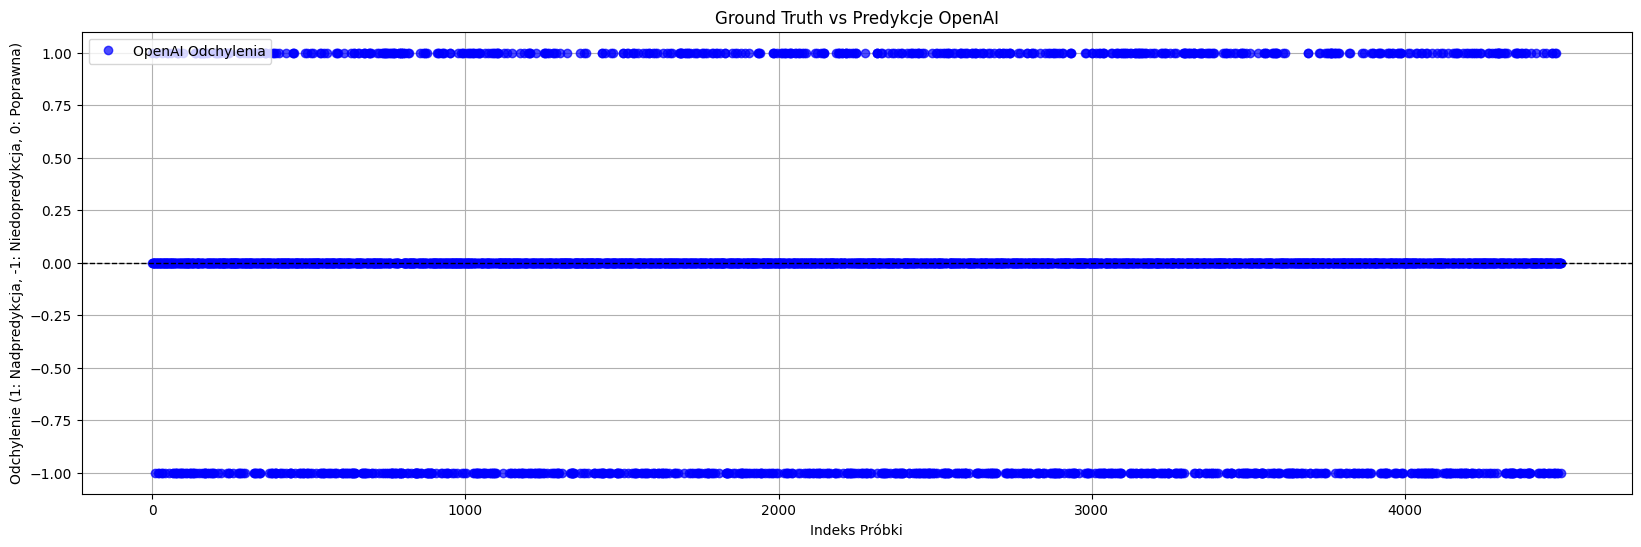

In [15]:
batch_size = 50
num_batches = 90  
print("Pobieranie danych z OpenAI API...")
openai_preds = classify_with_openai_in_batches(texts, batch_size, num_batches)

# Przygotowwanie wykresu dokładności batchy
batch_accuracies = []
for batch_num in range(num_batches):
    start_idx = batch_num * batch_size
    end_idx = start_idx + batch_size
    batch_preds = openai_preds[start_idx:end_idx]  # Predykcje dla tego batcha
    batch_labels = true_labels[start_idx:end_idx]  # Prawdziwe etykiety dla tego batcha

    batch_accuracy = accuracy_score(batch_labels, batch_preds)
    batch_accuracies.append(batch_accuracy)

# Tworzenie wykresu dokładności dla każdego batcha
plt.figure(figsize=(20, 6))
plt.plot(range(1, num_batches + 1), batch_accuracies, marker='o', linestyle='-', color='blue', alpha=0.7)
plt.title("Dokładność dla każdego batcha")
plt.xlabel('Numer Batcha')
plt.ylabel('Dokładność')
plt.grid(True)
plt.show()

# Oblicz dokładność i wyświetl raport klasyfikacji
openai_accuracy = accuracy_score(true_labels[0:len(openai_preds)], openai_preds)
print(f"Dokładność OpenAI API: {openai_accuracy:.2f}")
print("Raport klasyfikacji OpenAI API:")
print(classification_report(true_labels[0:len(openai_preds)], openai_preds))

deviations = [1 if pred > true else -1 if pred < true else 0 for true, pred in zip(true_labels, openai_preds)]

# Tworzenie wykresu odchyleń
plt.figure(figsize=(20, 6))
plt.plot(deviations, marker='o', linestyle='', label='OpenAI Odchylenia', color='blue', alpha=0.7)
plt.axhline(0, color='black', linewidth=1, linestyle='--') # Linia bazowa dla braku odchylenia
plt.title("Ground Truth vs Predykcje OpenAI")
plt.xlabel('Indeks Próbki')
plt.ylabel('Odchylenie (1: Nadpredykcja, -1: Niedopredykcja, 0: Poprawna)')
plt.legend()
plt.grid(True)
plt.show()

Usuwamy stworzone pliki JSONL

In [16]:
files_to_delete = [
    "twitter-sentiment-analysis-train.jsonl",
    "twitter-sentiment-analysis-validation.jsonl",
    "twitter-sentiment-analysis-test.jsonl"
]

# Usuwanie plików
for file in files_to_delete:
    if os.path.exists(file):
        os.remove(file)
        print(f"Usunięto plik: {file}")
    else:
        print(f"Plik {file} nie istnieje.")

Usunięto plik: twitter-sentiment-analysis-train.jsonl
Usunięto plik: twitter-sentiment-analysis-validation.jsonl
Usunięto plik: twitter-sentiment-analysis-test.jsonl
